# Лабораторная работа 5
Выполнила Карасева Екатерина M33351

## Композиция алгоритмов

Чтение данных

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('chips.csv')
if 'weight' not in df.index:
    df['weight'] = [1] * len(df)
df

,x,y,class,weight
0,0.051267,0.699560,P,1
1,-0.092742,0.684940,P,1
2,-0.213710,0.692250,P,1
3,-0.375000,0.502190,P,1
4,-0.513250,0.465640,P,1
...,...,...,...,...
113,-0.720620,0.538740,N,1
114,-0.593890,0.494880,N,1
115,-0.484450,0.999270,N,1
116,-0.006336,0.999270,N,1


Решающее дерево

In [2]:
def get_accuracy(classifier, data):
    true = 0
    for _, obj in data.iterrows():
        target = obj['class']
        predicted = classifier(obj)
        true += (predicted == target)
    return true / len(data)

def get_lambda(ind, n):
    return lambda x: x[ind] > n, lambda x: x[ind] <= n

# IGain
def entropy(p):
    return - (p[0] * np.log2(p[0]) if p[0] > 0 else 0) \
           - (p[1] * np.log2(p[1]) if p[1] > 0 else 0)


def get_best_rule(feature, s):
    cnt = {'P': 0, 'N': 0}
    sum_s = 0
    for _, obj in s.iterrows():
        cnt[obj['class']] += obj['weight']
        sum_s += obj['weight']
    sorted_s = s.sort_values(by=feature)
    cnt_left = {'P': 0, 'N': 0}
    sum_left = 0
    cnt_right = {'P': cnt['P'], 'N': cnt['N']}
    sum_right = sum_s
    p_s = [cnt['P'] / sum_s, cnt['N'] / sum_s]
    branching_criteria = []
    for _, obj in sorted_s.iterrows():
        cnt_left[obj['class']] += obj['weight']
        sum_left += obj['weight']
        cnt_right[obj['class']] -= obj['weight']
        sum_right -= obj['weight']
        p_left = [cnt_left['P'] / sum_s, cnt_left['N'] / sum_s]
        p_right = [cnt_right['P'] / sum_s, cnt_right['N'] / sum_s]
        branching_criteria.append(entropy(p_s)
                                  - (sum_left / sum_s) * entropy(p_left)
                                  - (sum_right / sum_s) * entropy(p_right))
    return sorted_s.iloc[np.argmax(branching_criteria)][feature], np.max(branching_criteria)


class Node:
    def __init__(self):
        self.rule = None
        self.c = None
        self.left = None
        self.right = None
        self.max_depth = None
        self.depth = 0

    def fit(self, s):
        cnt = s['class'].value_counts()
        if self.max_depth is not None and self.depth == self.max_depth:
            self.c = cnt.index[0]
            return
        if len(cnt) == 1:
            self.c = cnt.index[0]
            return
        best_rule_x, max_x = get_best_rule('x', s)
        best_rule_y, max_y = get_best_rule('y', s)
        best_rule = get_lambda('x', best_rule_x) if max_x > max_y else get_lambda('y', best_rule_y)
        self.rule = best_rule[0]
        left = s[best_rule[0]]
        right = s[best_rule[1]]
        if len(left) == 0 or len(right) == 0:
            self.c = cnt.index[0]
            return
        self.left = Node()
        self.left.depth = self.depth + 1
        self.left.fit(s[best_rule[0]])
        self.right = Node()
        self.right.depth = self.depth + 1
        self.right.fit(s[best_rule[1]])

    def predict(self, obj):
        if self.c is not None:
            return self.c
        if self.rule(obj):
            return self.left.predict(obj)
        return self.right.predict(obj)

Рандомный лес

In [3]:
import collections
import random


class RandomForest:
    def __init__(self):
        self.forest = None

    def fit(self, data):
        self.forest = []
        for i in range(0, 100):
            s = pd.DataFrame([])
            for j in range(0, len(data)):
                ind = random.randint(0, len(data) - 1)
                s = pd.concat([s, data.iloc[ind]], ignore_index=True, axis=1)
            s = s.T
            root = Node()
            root.fit(s)
            self.forest.append(root)

    def predict(self, obj):
        votes = list(map(lambda tree: tree.predict(obj), self.forest))
        return collections.Counter(votes).most_common()[0][0]


forest = RandomForest()
forest.fit(df)
get_accuracy(forest.predict, df)


0.8983050847457628

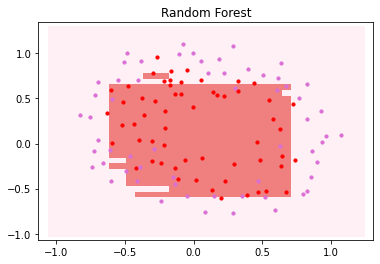

In [4]:
from matplotlib import pyplot as plt


def draw_plot(title, data, clf):
    plt.title(title)
    min_x1, max_x1 = data['x'].min(), data['x'].max()
    min_x2, max_x2 = data['y'].min(), data['y'].max()
    dx1 = max_x1 - min_x1
    dx2 = max_x2 - min_x2
    step1 = 10
    step2 = 30
    for x1 in np.arange(min_x1 - dx1 / step1, max_x1 + dx1 / step1, dx1 / step2):
        for x2 in np.arange(min_x2 - dx2 / step1, max_x2 + dx2 / step1, dx2 / step2):
            z = clf(pd.Series({'x': x1, 'y': x2}, index=['x', 'y']))
            c = 'w'
            c = 'lightcoral' if z == 'P' else c
            c = 'lavenderblush' if z == 'N' else c
            plt.scatter(x1, x2, color=c, s=150, marker='s')
    objects = data.drop(columns='class')
    target = data['class']
    for i in range(len(data)):
        features, label = objects.iloc[i], target[i]
        c = 'orchid' if label == 'N' else 'red'
        plt.scatter(features['x'], features['y'], color=c, s=10)
    plt.show()


draw_plot('Random Forest', df, forest.predict)

AdaBoost

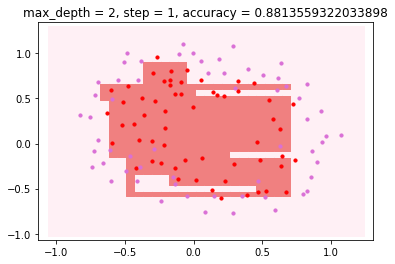

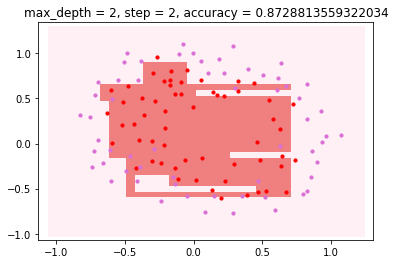

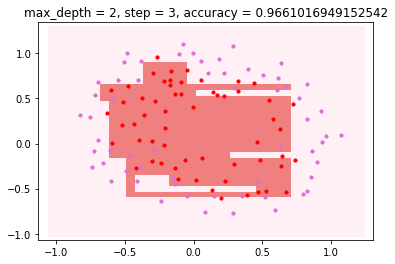

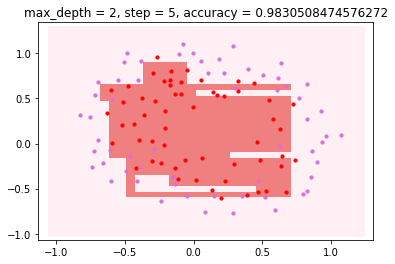

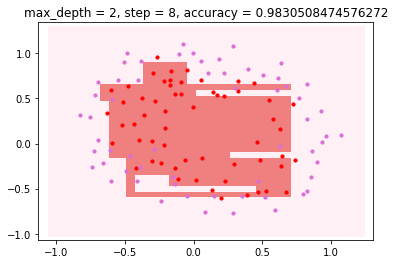

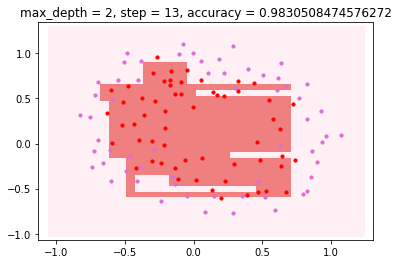

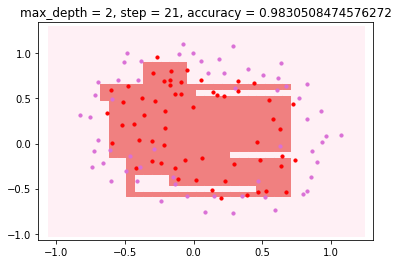

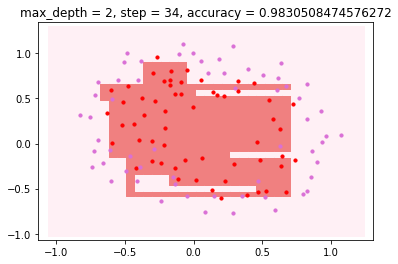

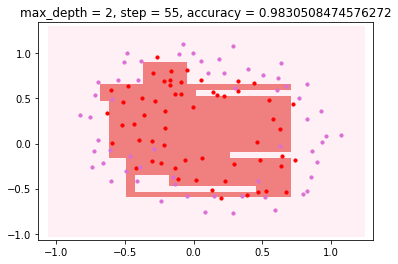

In [5]:
def get_N(data, tree):
    result = 0
    for _, obj in data.iterrows():
        target = 1 if obj['class'] == 'P' else -1
        predicted = 1 if tree.predict(obj) == 'P' else -1
        result += obj['weight'] * (target * predicted < 0)
    return result

def compose(trees, b):
    def f(x):
        predicted = 0
        for t in range(len(b)):
            predicted += b[t] * (1 if trees[t].predict(x) == 'P' else -1)
        return 'P' if np.sign(predicted) == 1 else 'N'

    return f

def adaBoost(data_train, data_test, max_depth=None, T=55):
    objects_count = len(data_train)
    data_train['weight'] = [(1 / objects_count) for _ in range(objects_count)]
    b = []
    trees = []
    steps = {1, 2, 3, 5, 8, 13, 21, 34, 55}
    results = []
    for t in range(T):
        tree = Node()
        tree.max_depth = max_depth
        tree.fit(data_train)
        trees.append(tree)
        N = get_N(data_train, tree)
        if N == 0:
            alpha_i = 0
        elif N == 1:
            alpha_i = 1
        else:
            alpha_i = 0.5 * np.log((1 - N) / N)
        b.append(alpha_i)
        new_w = []
        for i, obj in data_train.iterrows():
            y = 1 if obj['class'] == 'P' else -1
            predicted = 1 if tree.predict(obj) == 'P' else -1
            new_w.append(obj['weight'] * np.exp(-b[t] * y * predicted))
        data_train['weight'] = new_w
        weight_sum = np.sum(data_train['weight'])
        data_train['weight'] = data_train['weight'].apply(lambda w: w / weight_sum)
        if t + 1 in steps:
            current_classifier = compose(trees, b)
            accuracy = get_accuracy(current_classifier, data_test)
            results.append((t + 1, accuracy, current_classifier))
    return compose(trees, b), results

adaBoos_clf, res = adaBoost(df, df, max_depth=2, T=55)
for k, acc, clf in res:
    draw_plot('max_depth = {}, step = {}, accuracy = {}'.format(2, k, acc), df, clf)

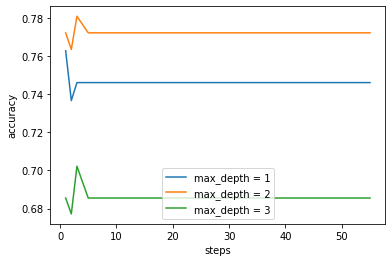

In [6]:
from sklearn.model_selection import KFold

def kfold_validate(data):
    kf = KFold(n_splits=5, shuffle=True)
    max_depths = [1, 2, 3]
    validation_results = {'max_depth': [], 'step': [], 'accuracy': []}
    steps = [1, 2, 3, 5, 8, 13, 21, 34, 55]
    ys = [[] for _ in range(len(max_depths))]
    for depth in max_depths:
        scores = {step: [] for step in steps}
        for train_index, test_index in kf.split(data):
            data_train = pd.DataFrame(data.iloc[train_index])
            data_test = pd.DataFrame(data.iloc[test_index])
            _, boost_result = adaBoost(data_train, data_test, max_depth=depth)
            for step, score, _ in boost_result:
                scores[step].append(score)
        for step in steps:
            score = np.mean(scores[step])
            validation_results['max_depth'].append(depth)
            validation_results['step'].append(step)
            validation_results['accuracy'].append(score)
            ys[depth - 1].append(score)
    for depth in max_depths:
        plt.plot(steps, ys[depth - 1], label='max_depth = {}'.format(depth))
    plt.legend(loc='lower center')
    plt.xlabel('steps')
    plt.ylabel('accuracy')
    plt.show()

kfold_validate(df)